In [ ]:
!ls

drive  sample_data


In [ ]:
# Installing libraries
!pip install texthero
!pip install -q kaggle
!pip install wordcloud
!pip install -U textblob
!python -m textblob.download_corpora

     |████████████████████████████████| 1.5MB 11.7MB/s 
     |████████████████████████████████| 245kB 35.7MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Requirement already up-to-date: textblob in /usr/local/lib/python3.7/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping cor

In [ ]:
from google.colab import files
#upload files
files.upload()

In [ ]:
# downloading dataset from kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip 'imdb-dataset-of-50k-movie-reviews.zip' -d kaggle_IMDB

# importing libraries

In [ ]:
#import libraries
import pandas as pd 
import matplotlib as plt
import seaborn as sns
import texthero as hero
from texthero import stopwords
import os 
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob,Word

nltk.download('words')
from nltk.corpus import words

import tensorflow as tf


os.chdir('/content/drive/MyDrive/Master Thesis')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Reading dataset

In [ ]:
#reading data
file_name='kaggle_IMDB/IMDB Dataset.csv'
#reading dataframe
df= pd.read_csv(file_name, header='infer')
df.head()


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

# Dataset preprocessing

In [ ]:
# function to lemmatize according to part of speech tag
def lemma_per_pos(sent):
    '''function to lemmatize according to part of speech tag'''
    # corpus of english words
    setofwords = set(words.words())
    t = TextBlob(sent)
    t_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    w_n_t = [(w, t_dict.get(p[0], 'n')) for w, p in t.tags]    
    lemmatized_list = [w.lemmatize(t) for w, t in w_n_t if w in setofwords]
    return " ".join(lemmatized_list)

def df_preprocessing(df,col_name):
    default_stopwords = stopwords.DEFAULT
    # adding some stop words as for movie review, 
    # so removing it
    custom_stopwords = default_stopwords.union(set(["movie","film"]))
    df[col_name]=[text.replace('<br','') for text in df[col_name]]
    # cleaning 
    df[col_name]= (
        df[col_name]
        .pipe(hero.clean)
        .pipe(hero.remove_html_tags)
        .pipe(hero.remove_brackets)
        .pipe(hero.remove_urls)
        )
    # lemmatization
    df[col_name]= [lemma_per_pos(sent) for sent in df[col_name]]
    df[col_name]= hero.remove_stopwords(df[col_name],custom_stopwords)
    return df

with tf.device('/GPU:0'):
    df= df_preprocessing(df,'review')
df.head()

review sentiment
0  one watch episode hook right exactly first thi...  positive
1  wonderful little production technique unassumi...  positive
2  think wonderful way spend time hot summer week...  positive
3  basically family little boy jake zombie closet...  negative
4  petter love time money visually stunning  watc...  positive

In [ ]:
df.to_csv('kaggle_IMDB/IMDB_Dataset_processed.csv')

# Length statistics

Max length: 4532, Min length: 21, Average Length :572


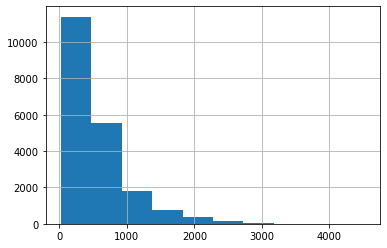

In [ ]:
# sentence lenght with space 
df['len']= df['review'].map(lambda x: len(x))
# sentence length without space
# df['len']= df['review']str.split().map(lambda x: len(x))
df.sort_values('len', ascending=False).reset_index(drop=True)
print('Max length: {}, Min length: {}, Average Length :{}'.format(max(df['len']),min(df['len']),int(df['len'].mean())))
df['len'].hist()


# Word frequencies 

## word level exploration

In [ ]:
# creating text corpus
text= ' '.join(t for t in df['review'])
words_list= text.split()
word_freq= {}
for word in set(words_list):
    
    word_freq[word]= words_list.count(word)

df_word= pd.DataFrame(word_freq.items(),columns=['word','count'])


In [ ]:
df_word['word_len']= df_word['word'].map(lambda x: len(x))
df_word=df_word.sort_values('count',ascending=False).reset_index(drop=True)
df_word

word  count  word_len
0                 one  21412         3
1                 see  16221         3
2                like  16181         4
3                make  15047         4
4                good  13628         4
...               ...    ...       ...
24001        eastward      1         8
24002  unflatteringly      1        14
24003      dispersion      1        10
24004           acrid      1         5
24005         blucher      1         7

[24006 rows x 3 columns]

In [ ]:
df_word.head(10)

word  count  word_len
0    one  21412         3
1    see  16221         3
2   like  16181         4
3   make  15047         4
4   good  13628         4
5   time  12610         4
6    get  11776         3
7   well  11233         4
8     go  10956         2
9  watch  10391         5

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



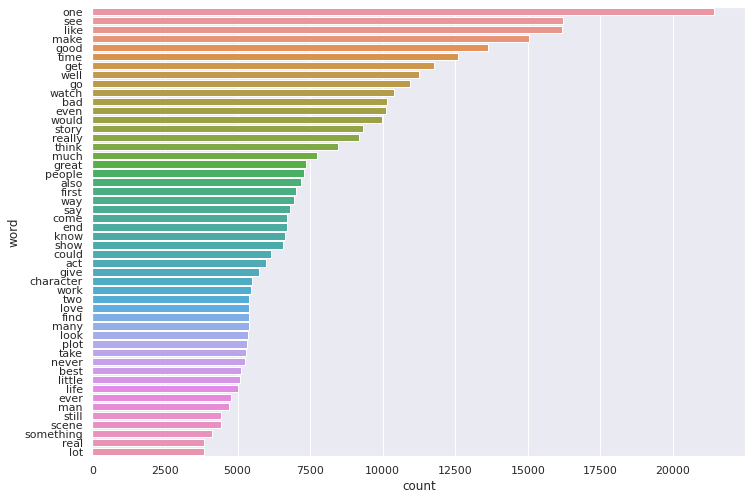

In [ ]:
# plotting only top 50 words
sns.set(rc={'figure.figsize':(11.7,8.27)})
df_top= df_word.head(50)
sns.barplot(df_top['count'],df_top['word'])

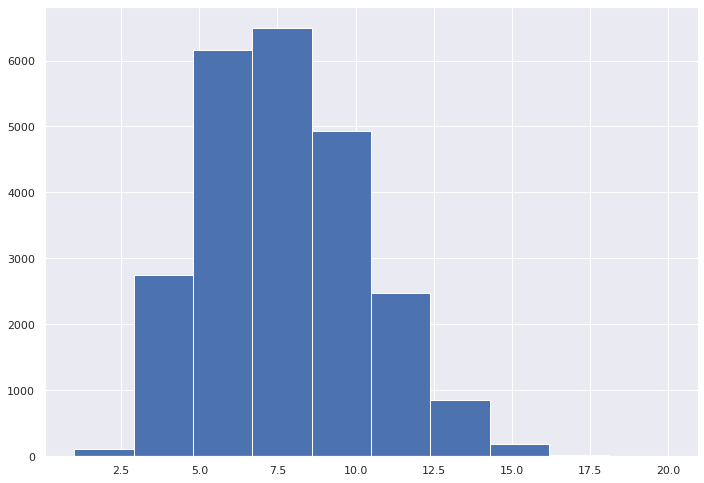

In [ ]:
df_word['word_len'].hist()

In [ ]:
df_word[df_word['word_len']==max(df_word['word_len'])]

word  count  word_len
10842  uncharacteristically      7        20
22073  institutionalization      1        20

# n grams 

In [ ]:
df['pca'] = (
   df['review']
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='sentiment', title="sentiment")

In [ ]:
df['kmeans_labels'] = (
    df['review']
    .pipe(hero.tfidf)
    .pipe(hero.kmeans, n_clusters=2)
    .astype(str)
)
sns.set(rc={'figure.figsize':(8.7,8.27)})
hero.scatterplot(df, 'pca', color='kmeans_labels', title="K-means")

In [ ]:
sns.set(rc={'figure.figsize':(8.7,8.27)})
hero.scatterplot(df, 'pca', color='kmeans_labels', title="K-means")

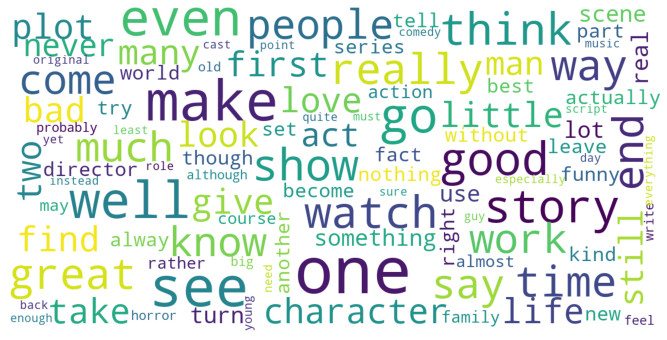

In [ ]:
# Generate a word cloud image
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white',
        max_words=100,
        max_font_size=40,
        scale=3,
        random_state=1).generate(text)
plt.axis("off")
plt.imshow(wordcloud)

In [ ]:
df['review'][8]

'positive  look forward watch  bad mistake see truly one bad awful almost every way act  song lame country tune less four time  cheap nasty boring extreme rarely happy see end  thing give score far best performance least make bite effort one'

In [ ]:
TextBlob(df['review'][8]).sentiment

Sentiment(polarity=-0.21174242424242423, subjectivity=0.7211038961038961)

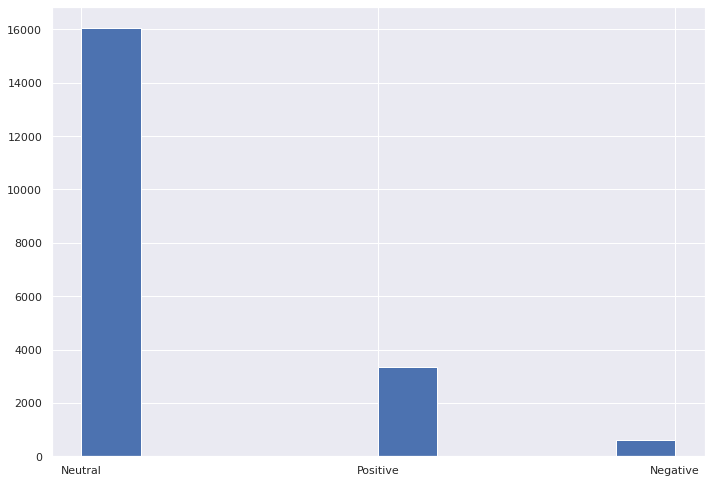

In [ ]:
def polarity(x):
    if TextBlob(x).sentiment[0]<-0.25:
        return 'Negative'
    if TextBlob(x).sentiment[0]>0.25:
        return 'Positive'
    return 'Neutral'

df['sentiment']= df['review'].map(lambda x: polarity(x))
df['sentiment'].hist()


In [ ]:

df['sentiment']=df['sentiment'].map(lambda x: polarity(x))

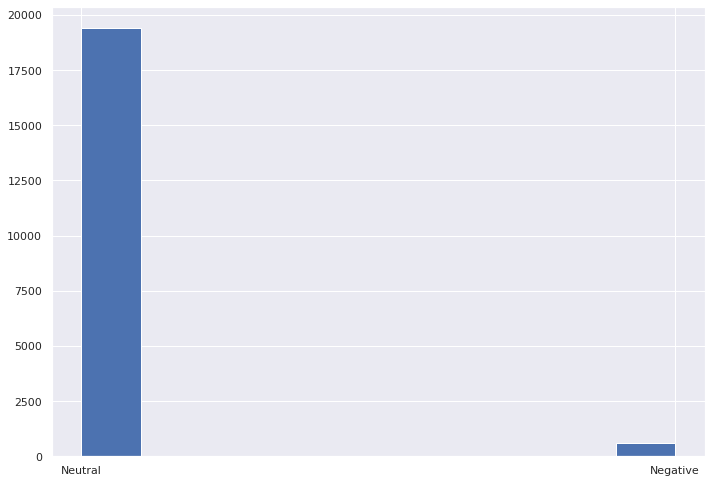

In [ ]:
df['sentiment'].hist()